In [1]:
%cd "G:\My Drive\hdsp\proyectos\seismic_craft"

G:\My Drive\hdsp\proyectos\seismic_craft


In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


## Inputs

Let’s define some inputs for the run:

-  ``workers`` - the number of worker threads for loading the data with
   the ``DataLoader``.
-  ``batch_size`` - the batch size used in training. The DCGAN paper
   uses a batch size of 128.
-  ``image_size`` - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details.
-  ``nc`` - number of color channels in the input images. For color
   images this is 3.
-  ``nz`` - length of latent vector.
-  ``ngf`` - relates to the depth of feature maps carried through the
   generator.
-  ``ndf`` - sets the depth of feature maps propagated through the
   discriminator.
-  ``num_epochs`` - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer.
-  ``lr`` - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002.
-  ``beta1`` - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5.
-  ``ngpu`` - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs.




In [4]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 512

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr =  0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data



In [5]:
import os 
import torch 

from dataclasses import dataclass
from torchvision.utils import make_grid


from libs.utils import get_default_device
from libs.dataloader import get_dataloader, inverse_transform


from libs.diffusion.config import BaseConfig, TrainingConfig, ModelConfig

torch.Size([512, 1, 128, 128])


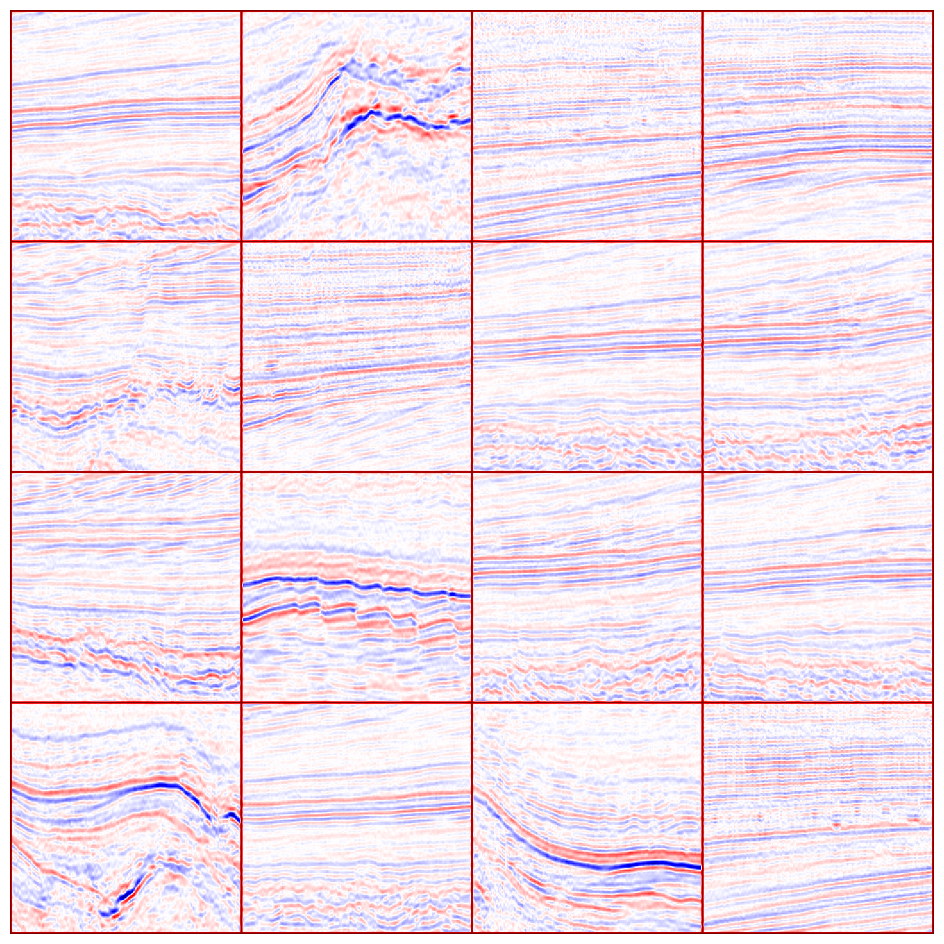

In [6]:
import matplotlib.pyplot as plt

device = get_default_device()

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=batch_size,
    device='cpu',
)

plt.figure(figsize=(12, 12), facecolor='white')

for b_image in loader:
    print(b_image.shape)
    b_image = b_image[:16]
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=4, padding=True, pad_value=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    plt.axis("off")
    break

## Implementation

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

### Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with ``mean=0``,
``stdev=0.02``. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator




Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [8]:
# Generator Code
from libs.adversarial.models import Generator


netG = Generator(nz, ngf, nc).to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm

### Discriminator




In [9]:
from libs.adversarial.models import Discriminator
# Create the Discriminator
netD = Discriminator(nc, ndf).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, 

In [10]:
# Initialize the ``BCELoss`` function
loss_fn = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
from libs.adversarial.train import train_one_epoch
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader    
    G_losses_i, D_losses_i = train_one_epoch(netD, netG, loader, optimizerD, optimizerG, loss_fn, epoch, device, nz)

    G_losses = G_losses + G_losses_i
    D_losses = D_losses + D_losses_i

Starting Training Loop...


KeyboardInterrupt: 

## Results

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




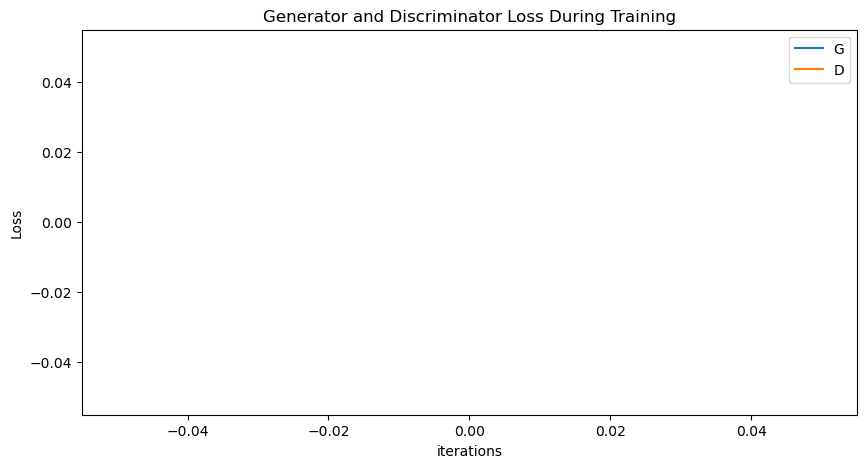

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




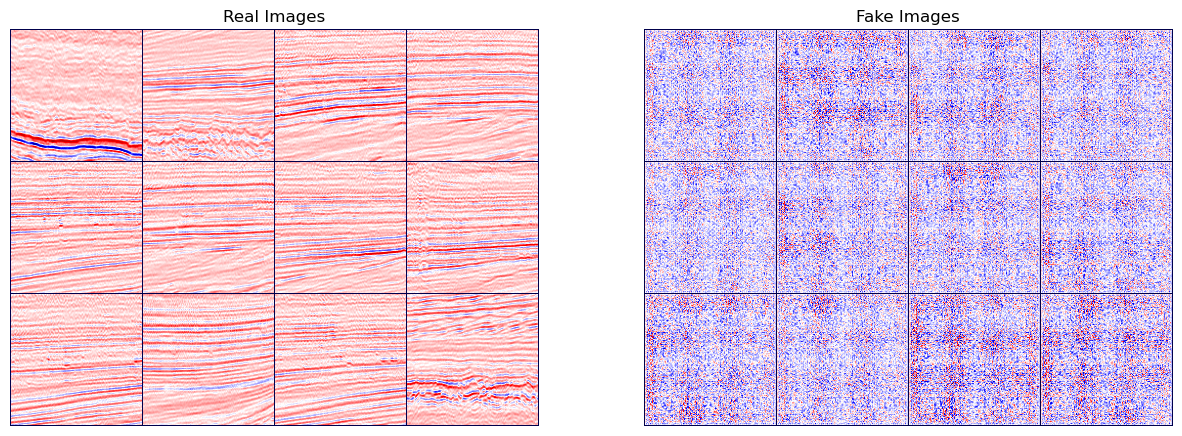

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))
fixed_noise = torch.randn(12, nz, 1, 1, device=device)

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list = vutils.make_grid(fake, padding=1, normalize=True, nrow=4)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:12], padding=1, normalize=True, nrow=4).cpu(),(1,2,0))[..., 0], cmap="seismic")

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list,(1,2,0))[..., 0], cmap="seismic")
plt.show()